## I. IMPORTATION DES DONNEES VIA L'API DE DATA.GOUV.FR

In [16]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [3]:
def recuperer_donnees(dataset_id, fichier_csv):
    """
    Cette fonction télécharge les données d'un fichier CSV à partir d'une URL et les charge dans un DataFrame pandas.
    
    Paramètres:
    dataset_id (str): idetifiant du fichier CSV.
    fichier_csv (str): Le nom du fichier CSV à enregistrer localement.
    
    Retourne:
    DataFrame: Un DataFrame pandas contenant les données du fichier CSV.
    """

    # URL de base pour accéder à l'API
    base_api = "https://www.data.gouv.fr/api/1/"

    # Chemin pour accéder aux enregistrements du dataset
    key_api = "datasets/r/"

    # Construction de l'URL complète
    url = f"{base_api}{key_api}{dataset_id}"


    response = requests.get(url)
    if response.status_code == 200:
        with open(fichier_csv, 'wb') as file:
            file.write(response.content)
        print("Le fichier a été téléchargé avec succès.")
        df = pd.read_csv(fichier_csv, sep = ";")
        return df
    else:
        print("La requête a échoué. Code d'état:", response.status_code)
        return None

In [4]:
# Chargement du fichier des usagers

dataset_id = "68848e2a-28dd-4efc-9d5f-d512f7dbe66f"
fichier_csv = "usagers-2023.csv"

df_usagers = recuperer_donnees(dataset_id,fichier_csv)
df_usagers.head()

Le fichier a été téléchargé avec succès.


,Num_Acc,id_usager,id_vehicule,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp
0,202300000001,203 851 184,155 680 557,A01,1,1,4,1,1978.0,5,2,0,-1,-1,-1,-1
1,202300000002,203 851 182,155 680 556,A01,1,1,1,2,1997.0,9,1,0,-1,-1,-1,-1
2,202300000002,203 851 183,155 680 556,A01,10,3,3,1,1997.0,9,0,-1,-1,2,3,1
3,202300000003,203 851 180,155 680 554,B01,1,1,3,1,1987.0,0,2,6,0,0,0,-1
4,202300000003,203 851 181,155 680 555,A01,1,1,1,2,1984.0,0,1,0,0,0,0,-1


In [5]:
# Chargement du fichier des véhicules

dataset_id = "146a42f5-19f0-4b3e-a887-5cd8fbef057b"
fichier_csv = "vehicules-2023.csv"

df_vehicules = recuperer_donnees(dataset_id,fichier_csv)
df_vehicules.head()

Le fichier a été téléchargé avec succès.


,Num_Acc,id_vehicule,num_veh,senc,catv,obs,obsm,choc,manv,motor,occutc
0,202300000001,155 680 557,A01,1,30,0,0,5,1,1,NaN
1,202300000002,155 680 556,A01,2,7,0,1,1,1,1,NaN
2,202300000003,155 680 554,B01,1,2,0,2,1,16,1,NaN
3,202300000003,155 680 555,A01,2,7,0,2,2,15,1,NaN
4,202300000004,155 680 551,B01,1,7,0,2,9,2,4,NaN


In [6]:
#Chargement du fichier des lieux

dataset_id = "8bef19bf-a5e4-46b3-b5f9-a145da4686bc"
fichier_csv = "lieux-2023.csv"

df_lieux = recuperer_donnees(dataset_id,fichier_csv)
df_lieux.head()

Le fichier a été téléchargé avec succès.


/tmp/ipykernel_2986/1884421158.py:28: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fichier_csv, sep = ";")


,Num_Acc,catr,voie,v1,v2,circ,nbv,vosp,prof,pr,pr1,plan,lartpc,larrout,surf,infra,situ,vma
0,202300000001,4,RUE DE RIVOLI,0,NaN,1,2,0,1,-1,-1,1,NaN,-1,2,0,1,30
1,202300000001,4,RUE SAINT FLORENTIN,0,NaN,1,1,0,1,-1,-1,1,NaN,-1,2,0,1,30
2,202300000002,3,120,0,NaN,2,3,2,1,-1,-1,1,NaN,-1,2,0,1,50
3,202300000003,3,5,0,NaN,2,4,0,1,1,0,1,NaN,-1,2,5,1,50
4,202300000003,3,87,0,NaN,2,4,0,1,1,0,1,NaN,-1,2,5,1,50


In [7]:
#Chargement du fichier des caracteristiques

dataset_id = "104dbb32-704f-4e99-a71e-43563cb604f2"
fichier_csv = "caract-2023.csv"

df_caract = recuperer_donnees(dataset_id,fichier_csv)
df_caract.head()


Le fichier a été téléchargé avec succès.


,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,atm,col,adr,lat,long
0,202300000001,7,5,2023,06:00,1,75,75101,2,4,2,7,RUE DE RIVOLI,"48,86638600","2,32347100"
1,202300000002,7,5,2023,05:30,5,94,94080,2,1,3,6,Avenue de Paris,"48,84547782","2,42868146"
2,202300000003,7,5,2023,20:50,1,94,94022,2,3,2,1,Avenue du Général Leclerc,"48,76240000","2,40655000"
3,202300000004,6,5,2023,23:57,5,94,94078,2,1,3,5,Rue de Paris,"48,73248432","2,44687575"
4,202300000005,7,5,2023,00:50,5,94,94068,2,2,3,3,56bis Avenue Raspail,"48,78581000","2,49217000"


On ne garde que les données qui nous intéressent : 
<br> - dans le fichier df_caract : Num_Acc, mois, lum, dep, com, agg, atm,lat, long
<br> - dans df_lieux : Num_Acc, catr, voie, surf, vma
<br> - dans df_vehicules : Num_Acc, id_vehicule, num_veh, catv, motor
<br> - dans df_usagers : Num_Acc, id_usager, id_vehicule, num_veh, catu, grav, trajet, secu

<br>Puis on fusionne les fichiers en un seul dataframe.

In [8]:
df_caract = df_caract.loc[:, ['Num_Acc', 'mois', 'lum', 'dep', 'com', 'agg', 'atm', 'lat', 'long']]
df_lieux = df_lieux.loc[:,['Num_Acc', 'catr', 'voie', 'surf', 'vma']]
df_vehicules = df_vehicules.loc[:,['Num_Acc', 'id_vehicule', 'num_veh', 'catv', 'motor']]
df_usagers = df_usagers.loc[:,['Num_Acc', 'id_usager', 'id_vehicule', 'num_veh', 'catu', 'grav', 'trajet', 'secu1', 'secu2', 'secu3']]

df = pd.merge(df_usagers, df_vehicules, on = ['Num_Acc', 'id_vehicule', 'num_veh'], how = 'inner')
df = pd.merge(df, df_lieux, on = "Num_Acc", how = 'inner')
df = pd.merge(df, df_caract, on = "Num_Acc", how = 'inner')

df.head(10)

,Num_Acc,id_usager,id_vehicule,num_veh,catu,grav,trajet,secu1,secu2,secu3,catv,motor,catr,voie,surf,vma,mois,lum,dep,com,agg,atm,lat,long
0,202300000001,203 851 184,155 680 557,A01,1,4,5,2,0,-1,30,1,4,RUE DE RIVOLI,2,30,5,1,75,75101,2,2,"48,86638600","2,32347100"
1,202300000001,203 851 184,155 680 557,A01,1,4,5,2,0,-1,30,1,4,RUE SAINT FLORENTIN,2,30,5,1,75,75101,2,2,"48,86638600","2,32347100"
2,202300000002,203 851 182,155 680 556,A01,1,1,9,1,0,-1,7,1,3,120,2,50,5,5,94,94080,2,3,"48,84547782","2,42868146"
3,202300000002,203 851 183,155 680 556,A01,3,3,9,0,-1,-1,7,1,3,120,2,50,5,5,94,94080,2,3,"48,84547782","2,42868146"
4,202300000003,203 851 180,155 680 554,B01,1,3,0,2,6,0,2,1,3,5,2,50,5,1,94,94022,2,2,"48,76240000","2,40655000"
5,202300000003,203 851 180,155 680 554,B01,1,3,0,2,6,0,2,1,3,87,2,50,5,1,94,94022,2,2,"48,76240000","2,40655000"
6,202300000003,203 851 181,155 680 555,A01,1,1,0,1,0,0,7,1,3,5,2,50,5,1,94,94022,2,2,"48,76240000","2,40655000"
7,202300000003,203 851 181,155 680 555,A01,1,1,0,1,0,0,7,1,3,87,2,50,5,1,94,94022,2,2,"48,76240000","2,40655000"
8,202300000004,203 851 175,155 680 551,B01,2,1,1,1,0,-1,7,4,2,6,2,50,5,5,94,94078,2,3,"48,73248432","2,44687575"
9,202300000004,203 851 176,155 680 551,B01,1,1,1,1,0,-1,7,4,2,6,2,50,5,5,94,94078,2,3,"48,73248432","2,44687575"


# II - Premières analyses

On commence par analyser l'impact de différents paramètres sur la gravité.



In [ ]:
df["(Num_Acc, id_usager)"] = list(zip(df["Num_Acc"], df["id_usager"]))
df = df[~df[["(Num_Acc, id_usager)"]].duplicated()]  #on supprime les doublons de (Num_Acc, id_usager)
                                                    # ces doublons existent par exemple lorsqu'un accident
                                                    # se produit à une intersection entre plusieurs voies
df.head(10)

df.groupby("grav").agg({"(Num_Acc, id_usager)": "nunique"})     #on compte toutes les victimes en fonction 
                                                                #de la gravité de leurs blessures

,"(Num_Acc, id_usager)"
grav,
-1,118
1,53399
2,3398
3,19271
4,49603


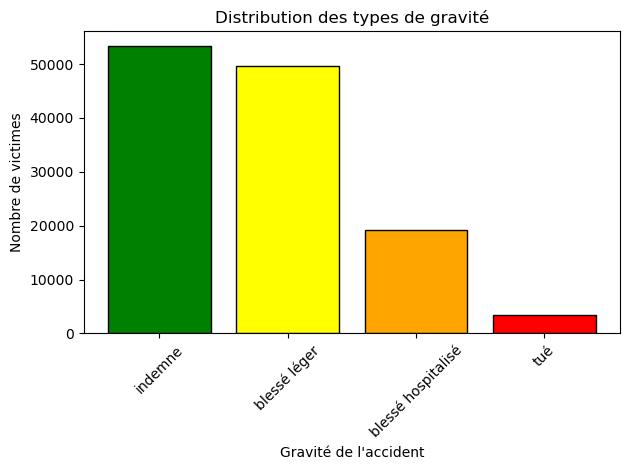

In [18]:
hist = { "grav": ["indemne", "blessé léger", "blessé hospitalisé", "tué"],
    "nb": [53399, 49603, 19271, 3398] }

plt.bar(hist["grav"], hist["nb"], color=['green', 'yellow', 'orange', 'red'], edgecolor='black')
plt.title("Distribution des types de gravité")
plt.xlabel("Gravité de l'accident")
plt.ylabel("Nombre de victimes")
plt.xticks(rotation=45)  # Rotation des labels pour meilleure lisibilité
plt.tight_layout()  # Ajustement automatique des marges
plt.show()

<BarContainer object of 9 artists>

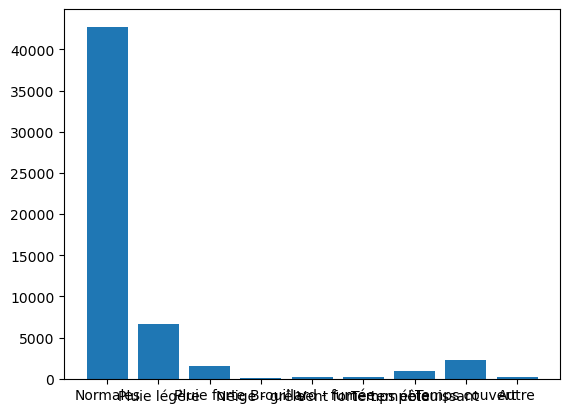

In [24]:
df_atm = df.groupby("atm").agg({"Num_Acc": "nunique"})
Num_Acc = df_atm["Num_Acc"].tolist()
Num_Acc.pop(0)

hist = { "atm" : ["Normales", "Pluie légère", "Pluie forte", "Neige - grêle", "Brouillard - fumée",
                  "Vent fort - tempête", "Temps éblouissant", "Temps couvert", "Autre"],
        "Num_Acc" : Num_Acc}
plt.bar(hist["atm"], hist["Num_Acc"])